In [ ]:
%pip install numpy

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 375.8 kB/s eta 0:00:0000:0100:02

[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: pip3.10 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺ 8.6/8.7 MB 416.2 kB/s eta 0:00:0100:01
ERROR: Exception:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/site-packages/pip/_vendor/urllib3/response.py", line 438, in _error_catcher
    yield
  File "/usr/local/lib/python3.10/site-packages/pip/_vendor/urllib3/response.py", line 561, in read
    data = self._fp_read(amt) if not fp_closed else b""
  File "/usr/local/lib/python3.10/site-packages/pip/_vendor/urllib3/response.py", line 527, in _fp_read
    return self._fp.read(amt) if amt is not None else 

In [8]:
%pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
  Using cached matplotlib-3.10.7-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (8.7 MB)
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.9/113.9 kB 166.5 kB/s eta 0:00:00a 0:00:01
  Using cached pillow-12.0.0-cp310-cp310-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (7.0 MB)
  Using cached contourpy-1.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (325 kB)
  Using cached fonttools-4.61.0-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (4.9 MB)
  Using cached kiwisolver-1.4.9-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.6 MB)

[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: pip3.10 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Standard Deviation (Verilog vs Python Model): 0.00027111
Standard Deviation (Verilog vs True Sigmoid): 0.02423048


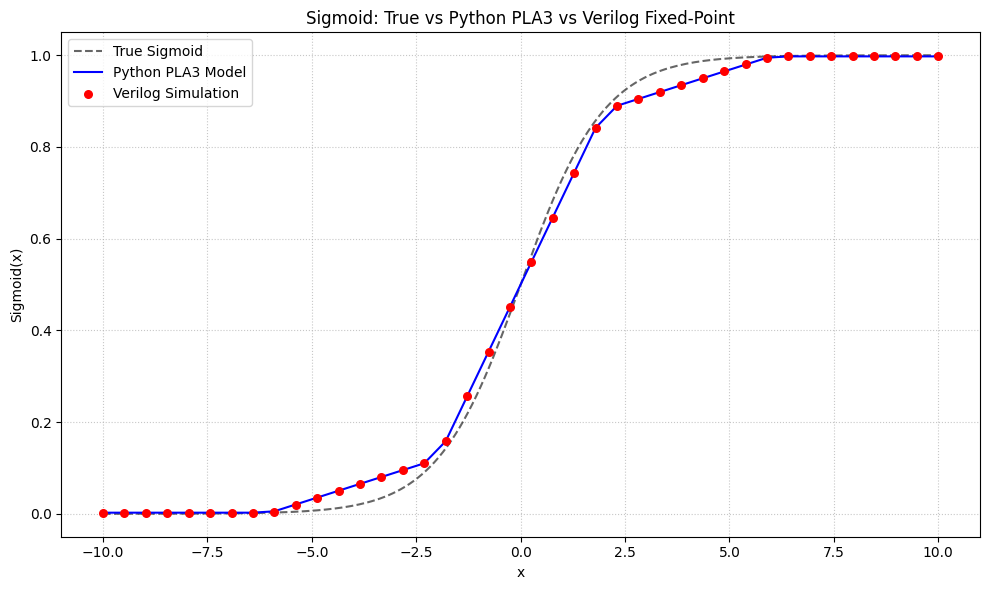

In [14]:
import numpy as np
import matplotlib.pyplot as plt

class PiecewiseSigmoid:
    def __init__(self, num_slices=10, input_range=(-6, 6)):
        self.num_slices = num_slices
        self.input_range = input_range
        self.breakpoints = np.linspace(input_range[0], input_range[1], num_slices + 1)
        self.slopes, self.intercepts = self._compute_segments()

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def _compute_segments(self):
        slopes = []
        intercepts = []
        for i in range(len(self.breakpoints) - 1):
            x1, x2 = self.breakpoints[i], self.breakpoints[i + 1]
            y1, y2 = self._sigmoid(x1), self._sigmoid(x2)
            slope = (y2 - y1) / (x2 - x1)
            intercept = y1 - slope * x1
            slopes.append(slope)
            intercepts.append(intercept)
        return slopes, intercepts

    def __call__(self, x):
        if isinstance(x, (int, float)):
            return self._evaluate(x)
        elif isinstance(x, np.ndarray):
            return np.array([self._evaluate(val) for val in x])
        else:
            raise ValueError("Input must be a scalar or a numpy array.")

    def _evaluate(self, x):
        if x <= self.breakpoints[0]:
            return self._sigmoid(self.breakpoints[0])
        elif x >= self.breakpoints[-1]:
            return self._sigmoid(self.breakpoints[-1])
        for i in range(len(self.breakpoints) - 1):
            if self.breakpoints[i] <= x < self.breakpoints[i + 1]:
                return self.slopes[i] * x + self.intercepts[i]
        return self._sigmoid(x)

# 1. Generate Data
# X values corresponding to the Verilog simulation (40 points from -10 to 10)
x_values_sim = np.linspace(-10, 10, 40)

# True Sigmoid
y_true = 1 / (1 + np.exp(-x_values_sim))

# Python PLA3 Model
sigmoid_approx3 = PiecewiseSigmoid(num_slices=3, input_range=(-6, 6))
y_pla3_python = sigmoid_approx3(x_values_sim)

# Verilog Simulation Results (Extracted from your table)
y_verilog = np.array([
    0.00244141, 0.00244141, 0.00244141, 0.00244141, 0.00244141, 0.00244141, 0.00244141, 0.00244141,
    0.00488281, 0.01953125, 0.03466797, 0.04980469, 0.06494141, 0.08007812, 0.09472656, 0.10986328,
    0.15820312, 0.25585938, 0.35351562, 0.45117188, 0.54833984, 0.64599609, 0.74365234, 0.84130859,
    0.88964844, 0.90478516, 0.91943359, 0.93457031, 0.94970703, 0.96484375, 0.97998047, 0.99462891,
    0.99755859, 0.99755859, 0.99755859, 0.99755859, 0.99755859, 0.99755859, 0.99755859, 0.99755859
])

# 2. Calculate Standard Deviation of Error
# Error vs Python Model (Quantization Noise)
error_vs_python = y_verilog - y_pla3_python
std_dev_quantization = np.std(error_vs_python)

# Error vs True Sigmoid (Total Approximation Error)
error_vs_true = y_verilog - y_true
std_dev_total = np.std(error_vs_true)

print(f"Standard Deviation (Verilog vs Python Model): {std_dev_quantization:.8f}")
print(f"Standard Deviation (Verilog vs True Sigmoid): {std_dev_total:.8f}")

# 3. Plotting
plt.figure(figsize=(10, 6))

# High resolution x for smooth True Sigmoid curve
x_smooth = np.linspace(-10, 10, 200)
plt.plot(x_smooth, 1 / (1 + np.exp(-x_smooth)), label="True Sigmoid", color='black', linestyle="--", alpha=0.6)

# Python PLA3 (Line)
plt.plot(x_values_sim, y_pla3_python, label="Python PLA3 Model", color="blue", linewidth=1.5)

# Verilog Simulation (Dots)
plt.scatter(x_values_sim, y_verilog, label="Verilog Simulation", color="red", s=30, zorder=5)

plt.legend()
plt.xlabel("x")
plt.ylabel("Sigmoid(x)")
plt.title("Sigmoid: True vs Python PLA3 vs Verilog Fixed-Point")
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

Standard Deviation (Verilog vs Python Model): 0.00025869
Standard Deviation (Verilog vs True Tanh): 0.04827892


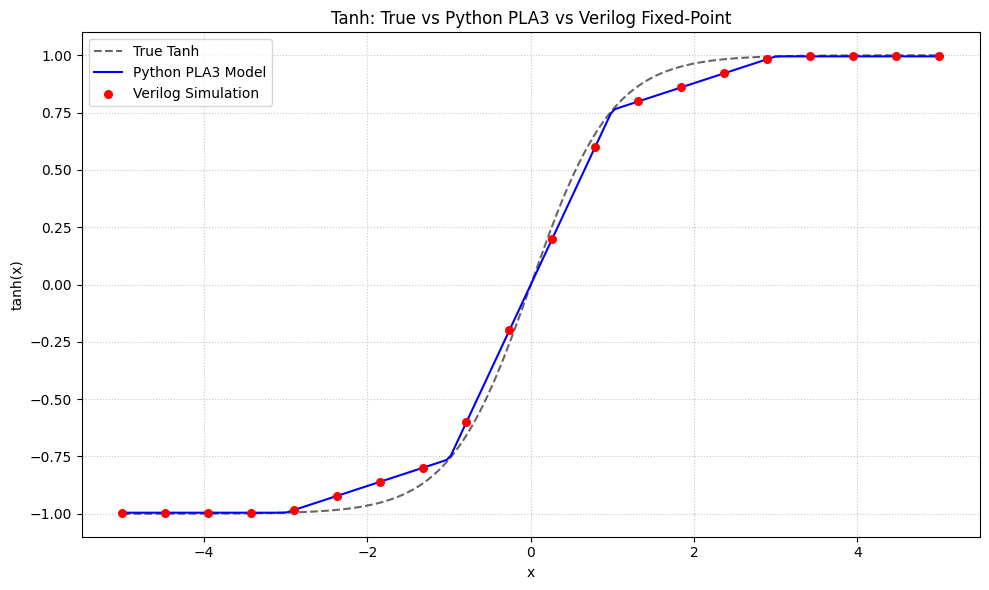

In [15]:
import numpy as np
import matplotlib.pyplot as plt

class PiecewiseTanh:
    def __init__(self, num_slices=10, input_range=(-3, 3)):
        """
        Piecewise-linear approximation of tanh(x).
        :param num_slices: number of linear segments.
        :param input_range: input range where approximation is built.
        """
        self.num_slices = num_slices
        self.input_range = input_range
        self.breakpoints = np.linspace(input_range[0], input_range[1], num_slices + 1)
        self.slopes, self.intercepts = self._compute_segments()

    def _tanh(self, x):
        """True tanh function."""
        return np.tanh(x)

    def _compute_segments(self):
        """Compute slope and intercept for each linear slice."""
        slopes = []
        intercepts = []
        for i in range(len(self.breakpoints) - 1):
            x1, x2 = self.breakpoints[i], self.breakpoints[i + 1]
            y1, y2 = self._tanh(x1), self._tanh(x2)
            slope = (y2 - y1) / (x2 - x1)
            intercept = y1 - slope * x1
            slopes.append(slope)
            intercepts.append(intercept)
        return slopes, intercepts

    def __call__(self, x):
        """Evaluate tanh approximation for scalar or np.ndarray."""
        if isinstance(x, (int, float)):
            return self._evaluate(x)
        elif isinstance(x, np.ndarray):
            return np.array([self._evaluate(val) for val in x])
        else:
            raise ValueError("Input must be scalar or numpy array.")

    def _evaluate(self, x):
        """Evaluate approximation for one input value."""
        # Outside the approximation range: clamp
        if x <= self.breakpoints[0]:
            return self._tanh(self.breakpoints[0])
        if x >= self.breakpoints[-1]:
            return self._tanh(self.breakpoints[-1])

        # Find interval
        for i in range(len(self.breakpoints) - 1):
            if self.breakpoints[i] <= x < self.breakpoints[i + 1]:
                return self.slopes[i] * x + self.intercepts[i]

        # Should never reach here
        return self._tanh(x)

# 1. Generate Data
# X values corresponding to the Verilog simulation (20 points from -5 to 5)
x_values_sim = np.linspace(-5, 5, 20)

# True Tanh
y_true = np.tanh(x_values_sim)

# Python PLA3 Model
tanh_approx3 = PiecewiseTanh(num_slices=3, input_range=(-3, 3))
y_pla3_python = tanh_approx3(x_values_sim)

# Verilog Simulation Results (Extracted from your table)
y_verilog = np.array([
    -0.99511719, -0.99511719, -0.99511719, -0.99511719,
    -0.98291016, -0.92138672, -0.86035156, -0.79882812,
    -0.60107422, -0.20019531,  0.19970703,  0.60058594,
     0.79833984,  0.85986328,  0.92089844,  0.98242188,
     0.99511719,  0.99511719,  0.99511719,  0.99511719
])

# 2. Calculate Standard Deviation of Error
# Error vs Python Model (Quantization Noise)
error_vs_python = y_verilog - y_pla3_python
std_dev_quantization = np.std(error_vs_python)

# Error vs True Tanh (Total Approximation Error)
error_vs_true = y_verilog - y_true
std_dev_total = np.std(error_vs_true)

print(f"Standard Deviation (Verilog vs Python Model): {std_dev_quantization:.8f}")
print(f"Standard Deviation (Verilog vs True Tanh): {std_dev_total:.8f}")

# 3. Plotting
plt.figure(figsize=(10, 6))

# High resolution x for smooth True Tanh curve and PLA model line
x_smooth = np.linspace(-5, 5, 200)
y_true_smooth = np.tanh(x_smooth)
y_pla3_smooth = tanh_approx3(x_smooth)

# True Tanh (Dashed Black Line)
plt.plot(x_smooth, y_true_smooth, label="True Tanh", color='black', linestyle="--", alpha=0.6)

# Python PLA3 (Blue Line) - Shows the segments
plt.plot(x_smooth, y_pla3_smooth, label="Python PLA3 Model", color="blue", linewidth=1.5)

# Verilog Simulation (Red Dots)
plt.scatter(x_values_sim, y_verilog, label="Verilog Simulation", color="red", s=30, zorder=5)

plt.legend()
plt.xlabel("x")
plt.ylabel("tanh(x)")
plt.title("Tanh: True vs Python PLA3 vs Verilog Fixed-Point")
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()